Let us start by importing important libraries. 

In [1]:
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Construct a Pipeline from the given estimators.
from sklearn.pipeline import make_pipeline


from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [2]:

path = "C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Capstone 3\\Pre-processing-notebooks\\Reviews_cleaned.csv"

reviews = pd.read_csv(path)

reviews.head(2)

,Reviewer_Score,review
0,0,park outside hotel beautiful angry make post a...
1,1,no real complaint hotel great great location s...


In [3]:
reviews['Reviewer_Score'].value_counts(normalize = True)

1    0.782609
0    0.217391
Name: Reviewer_Score, dtype: float64

Our target variable is 0 as it represents a negative review. We will build a train and test set. We will build a vectorizer using train set, and then use the transform function of the vectorizer to convert text data into a vector, which then will be used to create sampling method. 

##### Creating the Train/Test Split using stratification

In [4]:
from sklearn.model_selection import train_test_split


X = reviews.drop(['Reviewer_Score'], axis = 1)
y = reviews['Reviewer_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 0)

In [5]:
print("\n")
print("X_train:", type(X_train), X_train.shape) 

# AJS:
print("\n")
print("X_test", type(X_test), X_test.shape) 

print("\n")
print("y_train", type(y_train), y_train.shape) 

print("\n")
print("y_test", type(y_test), y_test.shape) 




X_train: <class 'pandas.core.frame.DataFrame'> (386803, 1)


X_test <class 'pandas.core.frame.DataFrame'> (128935, 1)


y_train <class 'pandas.core.series.Series'> (386803,)


y_test <class 'pandas.core.series.Series'> (128935,)


In [6]:
print("\n")
print("X_train:", X_train.head(3)) 

# AJS:
print("\n")
print("X_test", X_test.head(3)) 

print("\n")
print("y_train",  y_train.head(3)) 

print("\n")
print("y_test", y_test.head(3)) 




X_train:                                                    review
150921  minibar fruit basket clean sheet clean toilet ...
299878  hotel reception lovely think pay view harbour ...
440101  location perfect walk around shop food staff f...


X_test                                                    review
90246   personal polite really old hotel rather proper...
198661                                  look well nothing
489012  clean nice room wait long check bit really fau...


y_train 150921    1
299878    0
440101    1
Name: Reviewer_Score, dtype: int64


y_test 90246     0
198661    1
489012    1
Name: Reviewer_Score, dtype: int64


In [7]:
y_train.value_counts(normalize = True)

1    0.782608
0    0.217392
Name: Reviewer_Score, dtype: float64

In [8]:
y_test.value_counts(normalize = True)

1    0.782611
0    0.217389
Name: Reviewer_Score, dtype: float64

### Vectorizations

In [9]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 3), max_df=0.5)

count_vectorizer.fit(X_train['review'])

X_train_cv_vectors = count_vectorizer.transform(X_train['review'])
X_test_cv_vectors = count_vectorizer.transform(X_test['review'])

print("Train Vector Shape")
print(X_train_cv_vectors.shape)
print("Test Vector Shape")
print(X_test_cv_vectors.shape)

# Print the first 10 features of the count_vec
# print("Every feature:\n{}".formMat(count_vectorizer.get_feature_names()))
list(count_vectorizer.vocabulary_)[:10]


X_train_cv_vectors.dtype


Train Vector Shape
(386803, 5618607)
Test Vector Shape
(128935, 5618607)
Wall time: 1min 2s


dtype('int64')

In [10]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# word level
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), max_df=0.5)

tfidf.fit(X_train['review'])

X_train_tf_vector = tfidf.transform(X_train['review'])
X_test_tf_vector = tfidf.transform(X_test['review'])

print("Train Vector Shape")
print(X_train_tf_vector.shape)
print("Test Vector Shape")
print(X_test_tf_vector.shape)

list(tfidf.vocabulary_)[:10]

Train Vector Shape
(386803, 5618607)
Test Vector Shape
(128935, 5618607)
Wall time: 1min 8s


['minibar',
 'fruit',
 'basket',
 'clean',
 'sheet',
 'toilet',
 'no',
 'negative',
 'minibar fruit',
 'fruit basket']

##### Sampling using Random Under Sampler (RUS) & SMOTE For Count Vectorizer

In [13]:
# pip install --upgrade sklearn==0.23. 2
import joblib as jb
print("Done")




Done


In [15]:
%time
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus_cv, y_rus_cv, = rus.fit_resample(X_train_cv_vectors, y_train)
print("Done")


Wall time: 0 ns
Done


In [16]:
X_rus_cv.shape, y_rus_cv.shape

((168176, 5618607), (168176,))

In [18]:
y_rus_cv.value_counts(normalize = True)

0    0.5
1    0.5
Name: Reviewer_Score, dtype: float64

In [19]:
y_rus_cv.dtype

dtype('int64')

In [20]:
%%time
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 10)
X_smote_cv, y_smote_cv = smote.fit_resample(X_train_cv_vectors, y_train)
print("Done")



Done
Wall time: 4min 2s


In [21]:
X_smote_cv.shape, y_smote_cv.shape


((605430, 5618607), (605430,))

In [22]:
y_smote_cv.value_counts(normalize = True)

1    0.5
0    0.5
Name: Reviewer_Score, dtype: float64

In [23]:
X_smote_cv.dtype


dtype('int64')

##### Sampling using Random Under Sampler (RUS) & SMOTE For TF - IDF

In [24]:
%%time
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 10)
X_smote_tf, y_smote_tf = smote.fit_resample(X_train_tf_vector, y_train)
print("Done")



Done
Wall time: 4min 23s


In [25]:
X_smote_tf.shape, y_smote_tf.shape

((605430, 5618607), (605430,))

In [26]:
y_smote_tf.value_counts(normalize = True)

1    0.5
0    0.5
Name: Reviewer_Score, dtype: float64

In [27]:
%%time
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus_tf, y_rus_tf, = rus.fit_resample(X_train_tf_vector, y_train)
print("Done")


Done
Wall time: 182 ms


In [28]:
X_rus_tf.shape, y_rus_tf.shape

((168176, 5618607), (168176,))

In [29]:
y_rus_tf.value_counts(normalize = True)

0    0.5
1    0.5
Name: Reviewer_Score, dtype: float64

Let us create a custom function to evalute models performance with just one line of code. This will include Classification report/matrix, Confusion Matrix, & roc_auc curve. 

## Models

In [84]:
def ModelEval(y_test,predictions):
    print("precision_score1:",precision_score(y_test, predictions) )
    print("recall_score1:",recall_score(y_test, predictions))
    print("f1_score1:",f1_score(y_test, predictions))
    print("roc_auc score",roc_auc_score(y_test, predictions) )
    print("")

    print("[Test Classification Report]") 
    print(classification_report(y_test, predictions))
    print("")
    
    #condusion metrics
    cm = confusion_matrix(y_test, predictions)
    score = np.mean([y_test == predictions])
    #plot
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square = True,cbar = False);
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(predictions, y_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)


    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

#### 1) NaiveBayes with CV using RUS

In [31]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

In [32]:
%time nb.fit(X_rus_cv, y_rus_cv)

Wall time: 379 ms


MultinomialNB()

In [33]:
y_test_cv_rus_pred = nb.predict(X_test_cv_vectors)

precision_score1: 0.9457467611830849
recall_score1: 0.7668622282123957
f1_score1: 0.8469621181441065
roc_auc score 0.8042452708724043

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.50      0.84      0.63     28029
           1       0.95      0.77      0.85    100906

    accuracy                           0.78    128935
   macro avg       0.72      0.80      0.74    128935
weighted avg       0.85      0.78      0.80    128935




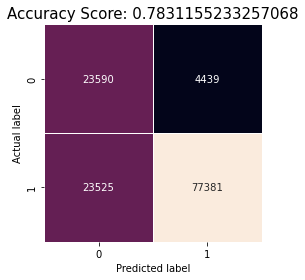

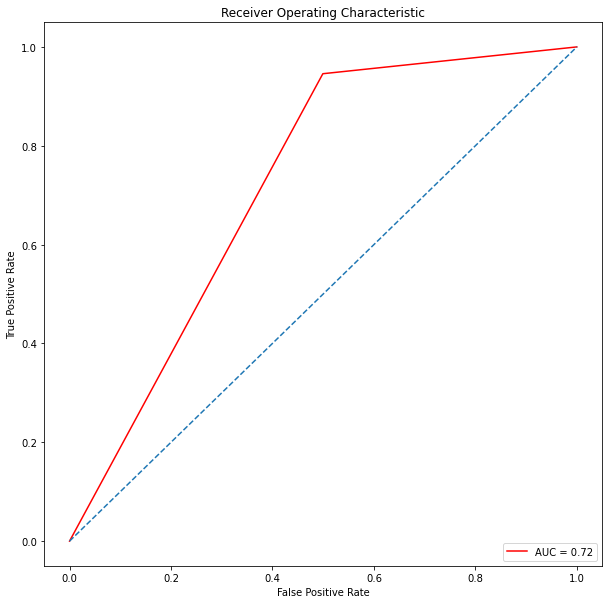

In [85]:
ModelEval(y_test, y_test_cv_rus_pred)

#### 2) NaiveBayes with CV using SMOTE

In [35]:
%time nb.fit(X_smote_cv, y_smote_cv)

Wall time: 738 ms


MultinomialNB()

In [94]:
y_test_cv_smote_nb_pred = nb.predict(X_test_cv_vectors)

precision_score1: 0.9407378475304478
recall_score1: 0.7876835867044576
f1_score1: 0.8574341271339572
roc_auc score 0.8045235872085919

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.52      0.82      0.64     28029
           1       0.94      0.79      0.86    100906

    accuracy                           0.80    128935
   macro avg       0.73      0.80      0.75    128935
weighted avg       0.85      0.80      0.81    128935




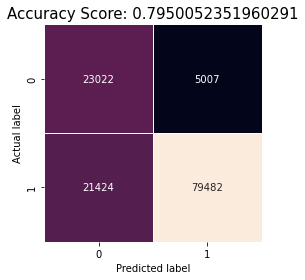

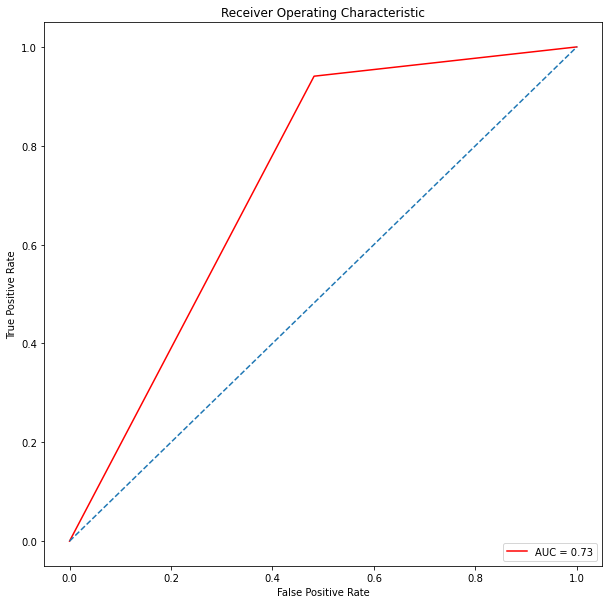

In [95]:
ModelEval(y_test, y_test_cv_smote_nb_pred)

#### 3) NaiveBayes with TF-IDF using SMOTE

In [38]:
%time nb.fit(X_smote_tf, y_smote_tf)

Wall time: 753 ms


MultinomialNB()

In [96]:
y_test_tf_smote_nb_pred = nb.predict(X_test_tf_vector)

precision_score1: 0.948307534045263
recall_score1: 0.7673973797395596
f1_score1: 0.8483145451956048
roc_auc score 0.8084016760626516

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.50      0.85      0.63     28029
           1       0.95      0.77      0.85    100906

    accuracy                           0.79    128935
   macro avg       0.73      0.81      0.74    128935
weighted avg       0.85      0.79      0.80    128935




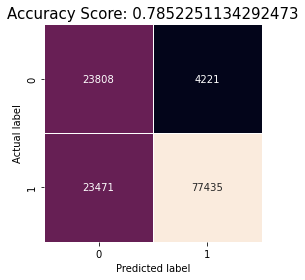

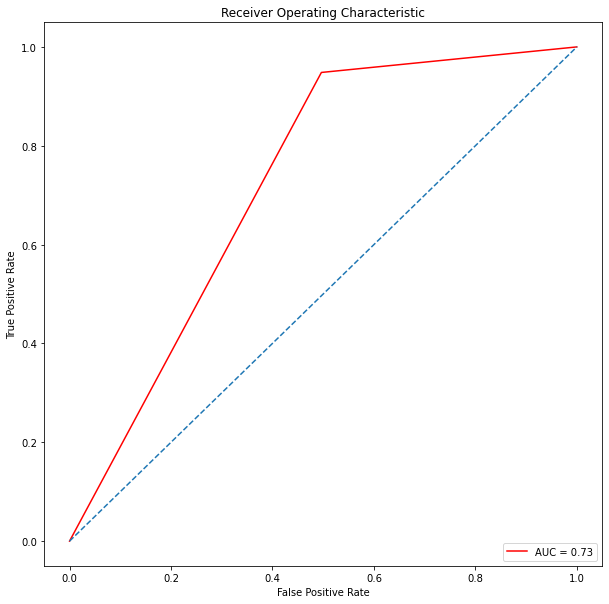

In [97]:
ModelEval(y_test, y_test_tf_smote_nb_pred)

#### 4) NaiveBayes with TF-IDF using RUS

In [41]:
%time nb.fit(X_rus_tf, y_rus_tf)

Wall time: 378 ms


MultinomialNB()

In [98]:
y_test_tf_rus_nb_pred = nb.predict(X_test_tf_vector)

precision_score1: 0.948307534045263
recall_score1: 0.7673973797395596
f1_score1: 0.8483145451956048
roc_auc score 0.8084016760626516

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.50      0.85      0.63     28029
           1       0.95      0.77      0.85    100906

    accuracy                           0.79    128935
   macro avg       0.73      0.81      0.74    128935
weighted avg       0.85      0.79      0.80    128935




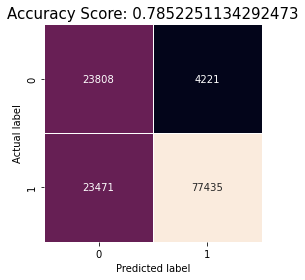

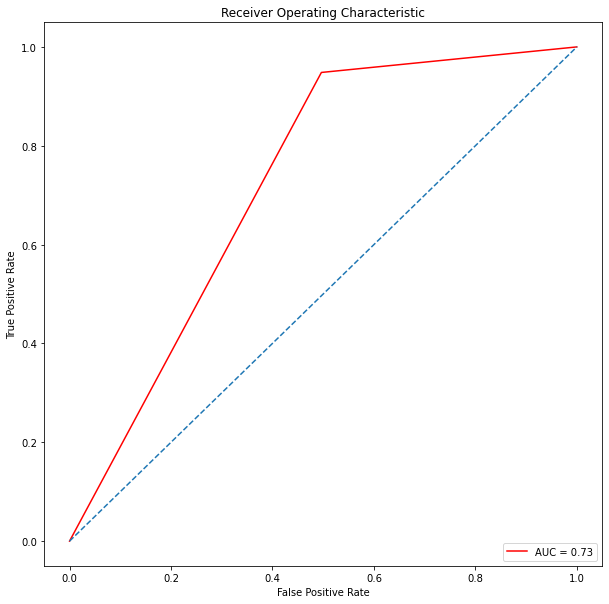

In [99]:
ModelEval(y_test, y_test_tf_rus_nb_pred)

#### 5) XGBoost with CV using RUS

In [44]:
import xgboost as xgb

xb = xgb.XGBClassifier()

xb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [45]:
xb_param_grid = {        
                 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                 "max_depth"        : [ 3, 5, 6, 8],
                 "min_child_weight" : [ 1, 3, 5, 7],
                 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    }

In [46]:
xg_r = RandomizedSearchCV(param_distributions = xb_param_grid, 
                                    estimator = xb, scoring = "f1", 
                                    verbose = 0, n_iter = 10, cv = 5)

In [47]:
%time xg_r.fit(X_rus_cv, y_rus_cv)

Wall time: 1h 35min 31s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 5, 6, 8],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1')

In [48]:
%time

xg_bp = xg_r.best_params_

print(f"Best Parameters: {xg_bp}")

print(f"Best Score: {xg_r.best_score_}")

Wall time: 0 ns
Best Parameters: {'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.5}
Best Score: 0.7960292345955116


In [49]:
%time
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

Wall time: 0 ns


In [50]:
%time xg_classifier.fit(X_rus_cv, y_rus_cv)

Wall time: 2min 38s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [100]:
y_test_cv_rus_xg_pred = xg_classifier.predict(X_test_cv_vectors)

precision_score1: 0.8111696020818628
recall_score1: 0.9452658910272927
f1_score1: 0.8730989093472102
roc_auc score 0.5765431813408254

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.51      0.21      0.30     28029
           1       0.81      0.95      0.87    100906

    accuracy                           0.78    128935
   macro avg       0.66      0.58      0.58    128935
weighted avg       0.75      0.78      0.75    128935




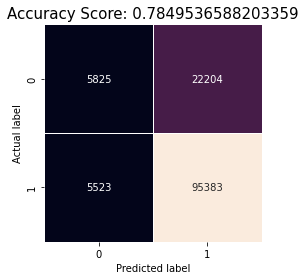

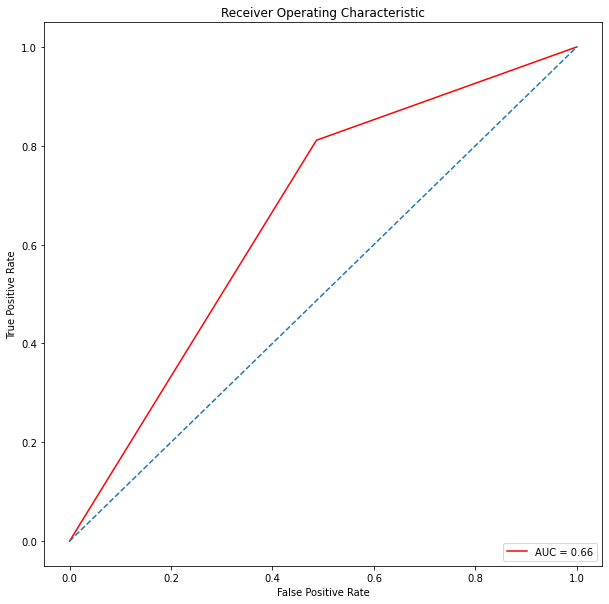

In [101]:
ModelEval(y_test, y_test_cv_rus_xg_pred)

#### 6) XGBoost with CV using SMOTE


In [53]:
%time xg_r.fit(X_smote_cv, y_smote_cv)

Wall time: 2h 7min 23s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 5, 6, 8],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1')

In [54]:
%time

xg_bp = xg_r.best_params_

print(f"Best Parameters: {xg_bp}")

print(f"Best Score: {xg_r.best_score_}")

Wall time: 0 ns
Best Parameters: {'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.3}
Best Score: 0.8839641873644585


In [55]:
%time
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

Wall time: 0 ns


In [56]:
%time xg_classifier.fit(X_smote_cv, y_smote_cv)

Wall time: 2min 35s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [102]:
y_test_cv_smote_xg_pred = xg_classifier.predict(X_test_cv_vectors)

precision_score1: 0.8111696020818628
recall_score1: 0.9452658910272927
f1_score1: 0.8730989093472102
roc_auc score 0.5765431813408254

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.51      0.21      0.30     28029
           1       0.81      0.95      0.87    100906

    accuracy                           0.78    128935
   macro avg       0.66      0.58      0.58    128935
weighted avg       0.75      0.78      0.75    128935




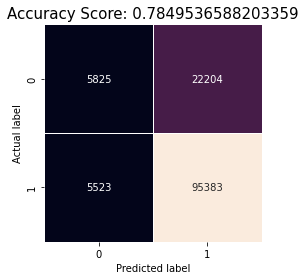

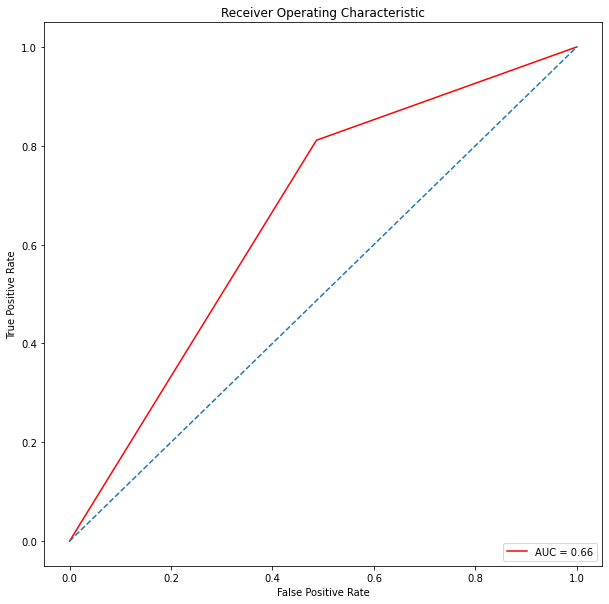

In [103]:
ModelEval(y_test, y_test_cv_smote_xg_pred)

#### 7) XGBoost with TF-IDF using RUS


In [59]:
%time xg_r.fit(X_rus_tf, y_rus_tf)

Wall time: 1h 56min 30s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 5, 6, 8],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1')

In [60]:
%time

xg_bp = xg_r.best_params_

print(f"Best Parameters: {xg_bp}")

print(f"Best Score: {xg_r.best_score_}")

Wall time: 0 ns
Best Parameters: {'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.3}
Best Score: 0.7863159521148526


In [61]:
%time
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

Wall time: 0 ns


In [62]:
%time xg_classifier.fit(X_rus_tf, y_rus_tf)

Wall time: 2min 30s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [104]:
y_test_tf_rus_xg_pred = xg_classifier.predict(X_test_tf_vector)

precision_score1: 0.8788355323718933
recall_score1: 0.908290884585654
f1_score1: 0.8933204674600621
roc_auc score 0.7287360448830015

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.62      0.55      0.58     28029
           1       0.88      0.91      0.89    100906

    accuracy                           0.83    128935
   macro avg       0.75      0.73      0.74    128935
weighted avg       0.82      0.83      0.83    128935




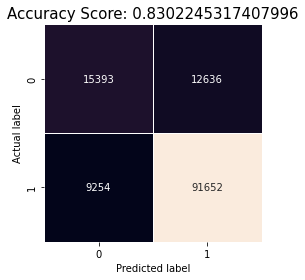

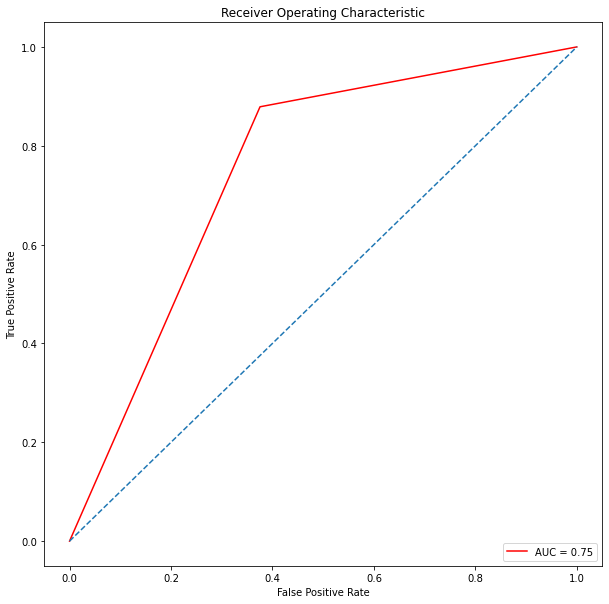

In [105]:
ModelEval(y_test, y_test_tf_rus_xg_pred)

#### 8) XGBoost with TF-IDF using SMOTE


In [65]:
%time xg_r.fit(X_smote_tf, y_smote_tf)

Wall time: 3h 41min 53s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 5, 6, 8],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1')

In [66]:
%time

xg_bp = xg_r.best_params_

print(f"Best Parameters: {xg_bp}")

print(f"Best Score: {xg_r.best_score_}")

Wall time: 0 ns
Best Parameters: {'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best Score: 0.8527240432680226


In [67]:
%time
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

Wall time: 0 ns


In [68]:
%time xg_classifier.fit(X_smote_tf, y_smote_tf)

Wall time: 7min 29s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [107]:
y_test_tf_smote_xg_pred = xg_classifier.predict(X_test_tf_vector)

precision_score1: 0.8788355323718933
recall_score1: 0.908290884585654
f1_score1: 0.8933204674600621
roc_auc score 0.7287360448830015

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.62      0.55      0.58     28029
           1       0.88      0.91      0.89    100906

    accuracy                           0.83    128935
   macro avg       0.75      0.73      0.74    128935
weighted avg       0.82      0.83      0.83    128935




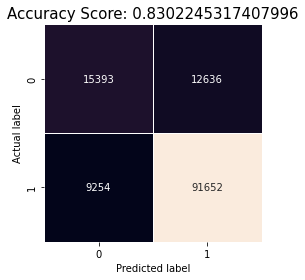

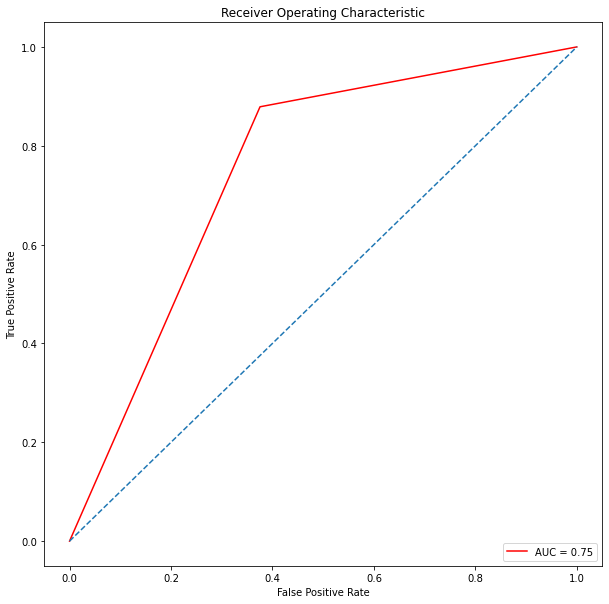

In [108]:
ModelEval(y_test, y_test_tf_smote_xg_pred)

#### 9) Random Forest with CV using RUS


In [71]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [72]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [73]:
rf_param_grid = {
                 'max_depth' : [4, 6, 8,10],
                 'n_estimators': range(1,10),
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10,20],
                 'min_samples_leaf': [1, 3, 10,18],
                 'bootstrap': [True, False]}

# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(rf, param_distributions=rf_param_grid, cv = 3, n_iter=10,verbose=1)

# Train on training data-
rs_cv.fit(X_rus_cv, y_rus_cv)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\hanna\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hanna\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hanna\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 10, 18],
                                        'min_samples_split': [2, 3, 10, 20],
                                        'n_estimators': range(1, 10)},
                   verbose=1)

In [74]:
print('Best score reached: {} with params: {} '.format(rs_cv.best_score_, rs_cv.best_params_))

Best score reached: 0.5881218805969134 with params: {'n_estimators': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True} 


In [75]:
rf_bp = rs_cv.best_params_

In [76]:
rf_classifier = RandomForestClassifier(n_estimators = rf_bp["n_estimators"],
                                     min_samples_split = rf_bp['min_samples_split'],
                                     min_samples_leaf = rf_bp['min_samples_leaf'],
                                     max_features = rf_bp['max_features'],
                                     max_depth = rf_bp['max_depth'],
                                     bootstrap = rf_bp['bootstrap'])

In [77]:
rf_classifier.fit(X_rus_cv, y_rus_cv)

RandomForestClassifier(max_depth=8, n_estimators=7)

In [109]:
y_test_cv_rus_pred_rf = rf_classifier.predict(X_test_cv_vectors)

precision_score1: 0.7939610814478542
recall_score1: 0.9740748815729491
f1_score1: 0.8748436825498547
roc_auc score 0.5320265591995467

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.49      0.09      0.15     28029
           1       0.79      0.97      0.87    100906

    accuracy                           0.78    128935
   macro avg       0.64      0.53      0.51    128935
weighted avg       0.73      0.78      0.72    128935




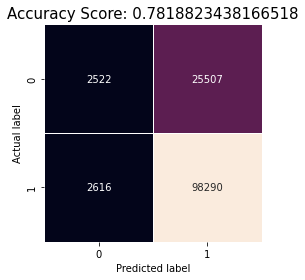

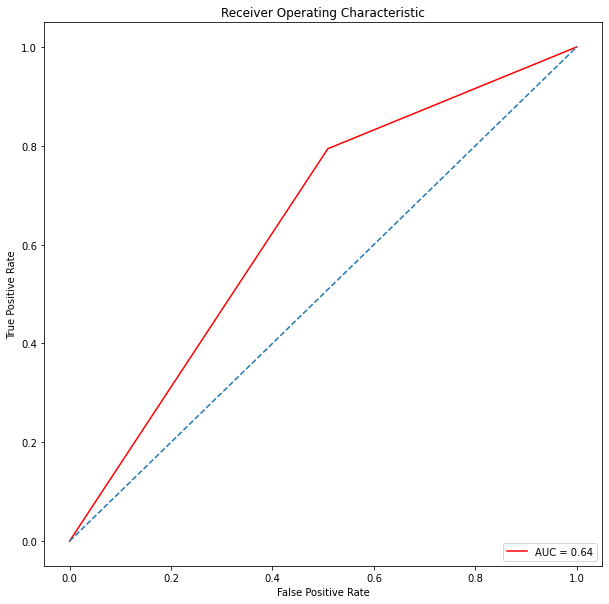

In [110]:
ModelEval(y_test, y_test_cv_rus_pred_rf)

In [114]:
data = {
    'Model': ['Naive Bayes', 'Naive Bayes', 'Naive Bayes', 'Naive Bayes', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'Random Forest'],
    'Sampling': ['RUS', 'SMOTE', 'SMOTE', 'RUS', 'RUS', 'SMOTE', 'RUS', 'SMOTE', 'RUS'],
    'Vectorizer':['CV', 'CV', 'TF-IDF', 'TF-IDF', 'CV', 'CV', 'TF-IDF', 'TF-IDF', 'CV'],
    '0: Precision': [0.50, 0.52, 0.50, 0.50, 0.51, 0.51, 0.62, 0.62, 0.49],
    '0: Recall':    [0.84, 0.82, 0.85, 0.85, 0.21, 0.21, 0.55, 0.55, 0.09],
    '1: Precision': [0.95, 0.94, 0.95, 0.95, 0.81, 0.81, 0.88, 0.88, 0.79],
    '1: Recall':    [0.77, 0.79, 0.77, 0.77, 0.95, 0.95, 0.91, 0.91, 0.91]}

df = pd.DataFrame(data)
df

,Model,Sampling,Vectorizer,0: Precision,0: Recall,1: Precision,1: Recall
0,Naive Bayes,RUS,CV,0.50,0.84,0.95,0.77
1,Naive Bayes,SMOTE,CV,0.52,0.82,0.94,0.79
2,Naive Bayes,SMOTE,TF-IDF,0.50,0.85,0.95,0.77
3,Naive Bayes,RUS,TF-IDF,0.50,0.85,0.95,0.77
4,XGBoost,RUS,CV,0.51,0.21,0.81,0.95
5,XGBoost,SMOTE,CV,0.51,0.21,0.81,0.95
6,XGBoost,RUS,TF-IDF,0.62,0.55,0.88,0.91
7,XGBoost,SMOTE,TF-IDF,0.62,0.55,0.88,0.91
8,Random Forest,RUS,CV,0.49,0.09,0.79,0.91


In [115]:
df.sort_values(by=['0: Recall'], ascending = False)

,Model,Sampling,Vectorizer,0: Precision,0: Recall,1: Precision,1: Recall
2,Naive Bayes,SMOTE,TF-IDF,0.50,0.85,0.95,0.77
3,Naive Bayes,RUS,TF-IDF,0.50,0.85,0.95,0.77
0,Naive Bayes,RUS,CV,0.50,0.84,0.95,0.77
1,Naive Bayes,SMOTE,CV,0.52,0.82,0.94,0.79
6,XGBoost,RUS,TF-IDF,0.62,0.55,0.88,0.91
7,XGBoost,SMOTE,TF-IDF,0.62,0.55,0.88,0.91
4,XGBoost,RUS,CV,0.51,0.21,0.81,0.95
5,XGBoost,SMOTE,CV,0.51,0.21,0.81,0.95
8,Random Forest,RUS,CV,0.49,0.09,0.79,0.91


To fully understand this, we must know what we are trying to approach. Our company wants the model to effectively predict the case of False negatives, given that our target class is 0 (negative). 

As a model, we want to predict the outcomes correctly and not penalize a hotel because of a model's inconsistency, or give a negative rating, when it really is a positive, hence our focus will be on the Recall method. Instead of looking at the number of false positives the model predicted, recall looks at the number of false negatives that were thrown into the prediction mix. 

We also see that Naive Bayes being a probabalistic machine learning model does better than our decision trees model.  

We do have a trade-off with Precision and as we learned, that will be the case most of the time where precision would suffer because recall is doing good, or vice versa.

Naive Bayes with TF-IDF Vectorization is the best model we have out of all. as it gives us the recall of 0.85. 